### Importación de Tensorflow

In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#importar celdas recurrentes 
from tensorflow.contrib import rnn
import csv
%matplotlib inline

### Importación de datos 

In [0]:
date=[]
High=[]
Low=[]
with open('hpq.us.txt', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for i,row in enumerate(spamreader):
        if i == 0:
            print(row)
            print(len(row))
        else: 
            date.append(row[0])
            
            High.append(float(row[2]))
            Low.append(float(row[3]))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
7


In [0]:
len(date)

12075

### verificando los datos de prueba

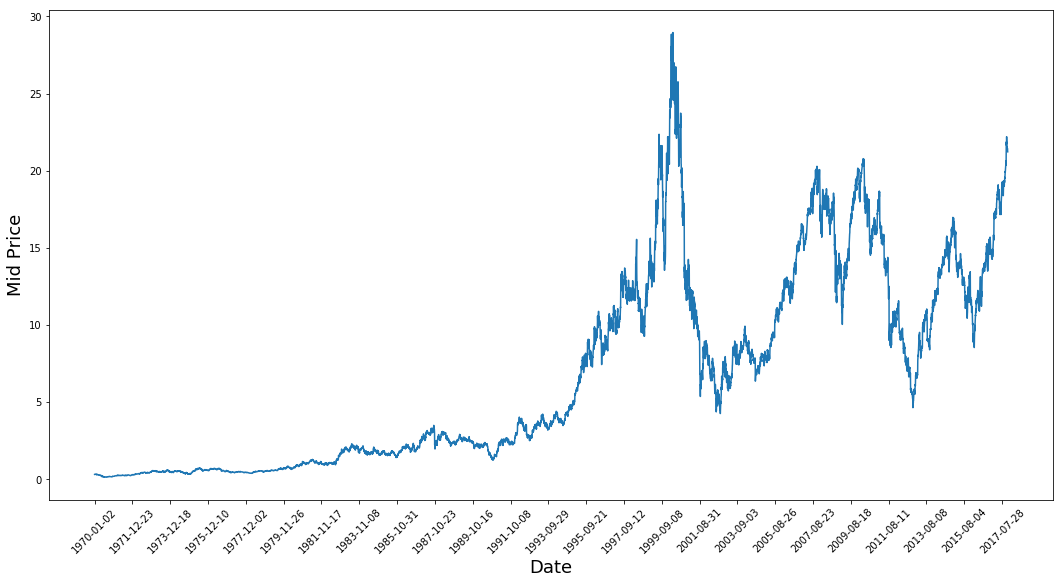

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(len(date)),(np.array(Low)+np.array(High))/2.0)
plt.xticks(range(0,len(date),500),date[0::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
mid_prices = (np.array(Low)+np.array(High))/2.0

In [0]:
Train_data = mid_prices[:11000]
Test_data = mid_prices

In [0]:
def data_genertor(data, window , distance=0):
    x=[]
    y=[]
    for i in range(len(data)-window-distance):
        x.append(data[i:i+window])
        y.append(data[i+window+distance])
    return np.array(x),np.array(y)

In [0]:
train_x,train_y=data_genertor(Train_data, 10 , 0)

In [0]:
print(train_x.shape)
print(train_y.shape)

(10990, 10)
(10990,)


In [0]:
test_x,test_y=data_genertor(Test_data, 10 , 0)

In [0]:
print(test_x.shape)
print(test_y.shape)

(12065, 10)
(12065,)


### Declarando la arquitectura

Generando función 

In [0]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [0]:
def Neural_network_model(
    chunk_size=1,
    n_chunks=10,
    rnn_size = 128,
    num_out=1
    ):
    reset_graph()
    # Declarando las entradas y salidas
    #x=tf.placeholder('float',[batch,inputSize])
    x_in=tf.placeholder('float',[None,n_chunks,chunk_size])
    y=tf.placeholder('float')
    #x=[[none,chunk_size],[none,chunk_size],[none,chunk_size],..,[none,chunk_size]]
    x = tf.transpose(x_in, [1,0,2])
    print(x.shape)
    x = tf.reshape(x, [-1, chunk_size])
    print(x.shape)
    x = tf.split(x, n_chunks, 0)
    print(x)
    
    # Declarando la arquitectura
    #(h,c)
    lstm_cell=tf.contrib.rnn.LSTMCell(rnn_size,state_is_tuple=True,num_proj=num_out)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    #print(outputs)
    #print(states)

    
    
   
    
  
    
    cost = tf.losses.mean_squared_error(y,outputs[ n_chunks-1])
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(cost)
    
    return dict(
              x=x_in,
              y=y,
              output=outputs[ n_chunks-1],
              cost=cost,
              optimizer=optimizer,
              saver = tf.train.Saver()  
              )

In [0]:
Neural_network_model()

(10, ?, 1)
(?, 1)
[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>]


{'cost': <tf.Tensor 'mean_squared_error/value:0' shape=<unknown> dtype=float32>,
 'optimizer': <tf.Operation 'Adam' type=NoOp>,
 'output': <tf.Tensor 'rnn/lstm_cell_9/projection/projection/MatMul:0' shape=(?, 1) dtype=float32>,
 'saver': <tensorflow.python.training.saver.Saver at 0x2569ed2f128>,
 'x': <tf.Tensor 'Placeholder:0' shape=(?, 10, 1) dtype=float32>,
 'y': <tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=float32>}

In [0]:
def train_neural_network(DNN, train_x, train_y, hm_epochs=100,batch_size=100,chunk_size=1,n_chunks=10,save=False):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(int(len(train_x)/batch_size)):
                epoch_x = train_x[batch_size*i:batch_size*(i+1)]
                epoch_y = train_y[batch_size*i:batch_size*(i+1)]
                epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))
                feed_dict={DNN["x"]: np.array(epoch_x), DNN["y"]: epoch_y}
                _, c, prediction,y   = sess.run([DNN["optimizer"], DNN["cost"]
                                                 , DNN["output"], DNN["y"]], 
                                                feed_dict=feed_dict)
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)
            
        if isinstance(save, str):
            ENCname="./SVE/"+save+".ckpt"
            DNN['saver'].save(sess, ENCname)

       

In [0]:
DNN=Neural_network_model()
train_neural_network(DNN,train_x,train_y,save="RNN")

(10, ?, 1)
(?, 1)
[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>]
Epoch 0 completed out of 100 loss: 1082.51594576
Epoch 1 completed out of 100 loss: 439.369044889
Epoch 2 completed out of 100 loss: 645.707184245
Epoch 3 completed out of 100 loss: 645.727803875
Epoch 4 completed out of 100 loss: 502.922159848
Epoch 5 completed out of 100 loss: 372.090253438
Epoch 6 completed out of 100 loss: 382.39506257
Epoch 7 completed out of 100 loss: 676.798807542
Epoch 8 completed out of 100 loss: 557.360657292
Epoch 9 completed out of 100 loss: 593.61

In [0]:
def Predictor(DNN,data,target,save=False):
    with tf.Session() as sess:
        ENCname="./SVE/"+save+".ckpt"
        DNN['saver'].restore(sess, ENCname)
        output=[]
        for i in range(len(data)):
            #Prueba con datos nunca antes vistos  
           
            epoch_x = data[i].reshape((1,10,1))
            prediction,y   = sess.run([DNN["output"], DNN["y"]], feed_dict={DNN["x"]:epoch_x, DNN["y"]:target[i]})
            output.append(prediction)
    return np.array(output)

In [0]:
DNN=Neural_network_model()
modelo=Predictor(DNN,test_x,test_y,save="RNN")

(10, ?, 1)
(?, 1)
[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>]
INFO:tensorflow:Restoring parameters from ./SVE/RNN.ckpt


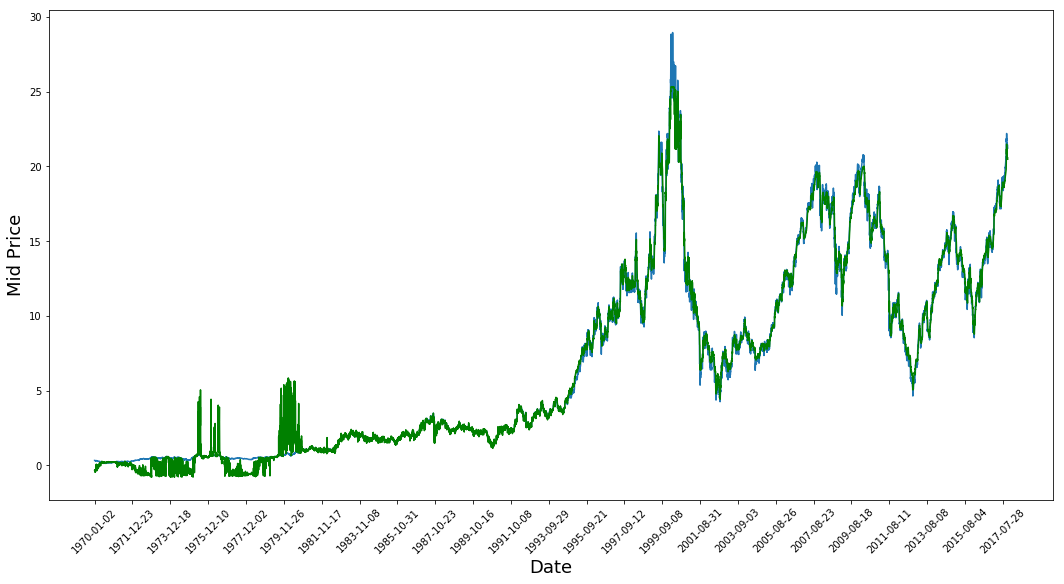

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(len(date[10:])),mid_prices[10:])
plt.plot(range(len(date[10:])),modelo.reshape((len(date[10:]))),color="green")
plt.xticks(range(0,len(date),500),date[0::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()